# Danh sách thành viên:

| MSSV|Họ và tên|
| ----------- | ----------- |
|20133029|Nguyễn Trí Dũng|
|20133090|Nguyễn Khoa Quang Thắng|
|20133076|Văn Mai Thanh Nhật|
|20133082|Huỳnh Minh Phước|

# Khai phá dữ liệu giao dịch của Website bán hàng

# Thư viện sử dụng

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from itertools import repeat
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
from os.path import exists
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# Thông tin tập dữ liệu

Link của tập dữ liệu: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business?select=Sales+Transaction+v.4a.csv

Tác giả: Gabriel Ramos

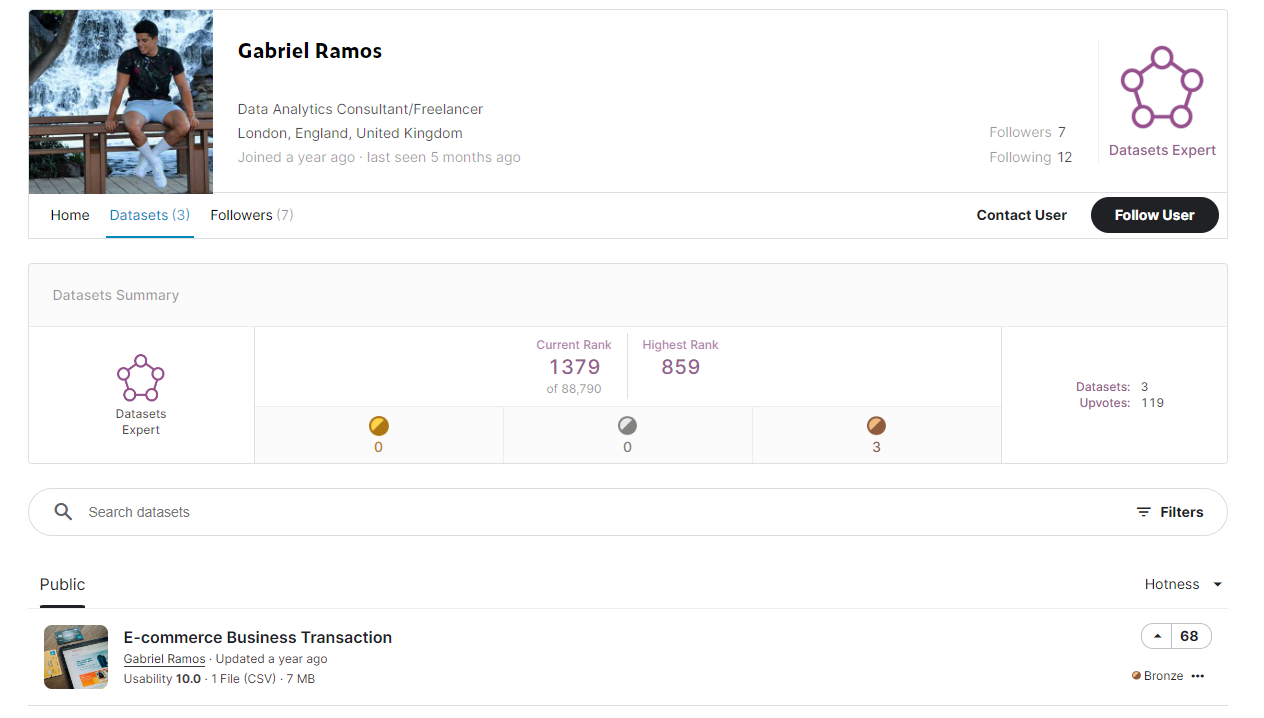

This is a sales transaction data set of UK-based e-commerce (online retail) for one year. This London-based shop has been selling gifts and homewares for adults and children through the website since 2007. Their customers come from all over the world and usually make direct purchases for themselves. There are also small businesses that buy in bulk and sell to other customers through retail outlet channels.

In [2]:
data = pd.read_csv("SalesTransaction.csv")

In [3]:
#data = data.head(10000)

Các attribute của tập dữ liệu:


The data set contains 500K rows and 8 columns. The following is the description of each column.

1. **TransactionNo (categorical):** a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.

2. **Date (numeric):** the date when each transaction was generated.

3. **ProductNo (categorical):** a five or six-digit unique character used to identify a specific product.

4. **Product (categorical):** product/item name.

5. **Price (numeric):** the price of each product per unit in pound sterling (£).

6. **Quantity (numeric):** the quantity of each product per transaction. Negative values related to cancelled transactions.

7. **CustomerNo (categorical):** a five-digit unique number that defines each customer.

8. **Country (categorical):** name of the country where the customer resides.

There is a small percentage of order cancellation in the data set. Most of these cancellations were due to out-of-stock conditions on some 
products. Under this situation, customers tend to cancel an order as they want all products delivered all at once.


# 1. Làm sạch dữ liệu:

## Xem 5 dòng đầu của tập dữ liệu:

In [ ]:
data.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


## Xem thông tin của tập dữ liệu:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [ ]:
data.shape

(536350, 8)

## Kiểm tra có dòng nào bị thiếu dữ liệu:

Có tổng cộng 55 dòng bị thiếu mất CustomerNo, nên ta sẽ xử lí 55 dòng bằng cách loại bỏ

In [ ]:
data.isnull().sum()

TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
dtype: int64

In [ ]:
data.dropna(inplace=True)

In [ ]:
data["CustomerNo"] = data["CustomerNo"].astype(str)
dateFormat = '%m/%d/%Y'
data['Date'] = pd.to_datetime(data['Date'],format = dateFormat)
data.info()

# EDA

In [ ]:
data["TotalMoney"] = data['Price']*data['Quantity']
data['Month'] = pd.DatetimeIndex(data['Date']).month
data['Year'] = pd.DatetimeIndex(data['Date']).year

## Số lượng của transaction bị huỷ

Lọc những transaction bị huỷ khỏi data và lưu lại vào CSV:

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalPrice
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64


In [ ]:
data_CancelTransaction = data.loc[data['Quantity']<0]
data_CancelTransaction.head()
data_CancelTransaction.to_csv('./data/data_CancelTransaction.csv')
data = data.loc[~(data['Quantity']<0)]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalPrice
1616,C581484,2019-12-09,23843,Paper Craft Little Birdie,6.19,-80995,16446.0,United Kingdom,-501359.05
1617,C581490,2019-12-09,22178,Victorian Glass Hanging T-Light,6.19,-12,14397.0,United Kingdom,-74.28
1618,C581490,2019-12-09,23144,Zinc T-Light Holder Stars Small,6.04,-11,14397.0,United Kingdom,-66.44
1619,C581568,2019-12-09,21258,Victorian Sewing Box Large,6.19,-5,15311.0,United Kingdom,-30.95
1620,C581569,2019-12-09,84978,Hanging Heart Jar T-Light Holder,6.19,-1,17315.0,United Kingdom,-6.19


Tính tổng số tiền chi tiêu của mỗi khách hàng:

In [ ]:
if not exists("./customer_quantity_price.csv"):
    customer_quantity_price = []
    for i in data['CustomerNo'].unique():
        sum_Quantity = data.loc[data['CustomerNo'] == i].Quantity.sum()
        sum_Price = data.loc[data['CustomerNo'] == i].TotalMoney.sum()
        customer_quantity_price.append([i, sum_Quantity,sum_Price])
    customer_quantity_price = pd.DataFrame(data=customer_quantity_price)
    customer_quantity_price.columns = ["CustomerNo", "TotalQuantity","TotalMoney"]
    customer_quantity_price.to_csv("./data/customer_quantity_price.csv",index=False)
else: customer_quantity_price = pd.read_csv("./customer_quantity_price.csv")

In [ ]:
customer_quantity_price.head()

,CustomerNo,TotalQuantity,TotalPrice
0,17490.0,1134,13538.07
1,13069.0,5885,63353.94
2,12433.0,11062,115454.49
3,13426.0,2245,25893.59
4,17364.0,2701,30254.25


Trực quan hoá số tiền chi tiêu của mỗi khách hàng:

<Axes: xlabel='TotalQuantity'>

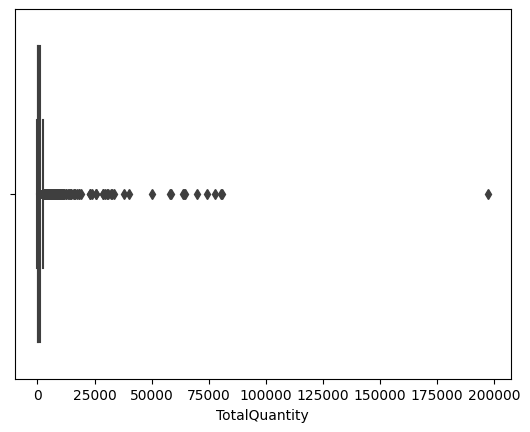

In [ ]:
sb.boxplot(x='TotalQuantity',data=customer_quantity_price)

# Tìm outlier khách hàng dựa theo TotalMoney và Quantity

## Tìm outlier theo phương pháp statistic:

Tính Q1, Q3, IQR

In [ ]:
Q1 = customer_quantity_price.TotalQuantity.quantile(0.25)
Q3 = customer_quantity_price.TotalQuantity.quantile(0.75)
IQR = Q3 - Q1
print("Q1: ",Q1)
print("Q3: ",Q3)
print("IQR: ",IQR)

Q1:  158.0
Q3:  1041.75
IQR:  883.75


Tìm outlier và xuất ra CSV:

In [ ]:
customer_quantity_price_outlier_statistic = customer_quantity_price.loc[(customer_quantity_price["TotalQuantity"] < Q1-1.5*IQR) | (customer_quantity_price["TotalQuantity"] > Q3+1.5*IQR)].sort_values(by="TotalQuantity",ascending=False)
print("Tổng số outlier: ",len(customer_quantity_price_outlier_statistic))
customer_quantity_price_outlier_statistic.to_csv("./data/customer_quantity_price_outlier_statistic.csv",index=False)
customer_quantity_price_outlier_statistic.head(10)

Tổng số outlier:  409


,CustomerNo,TotalQuantity,TotalPrice
75,14646.0,197420,2112282.03
6,16446.0,80997,1002741.57
125,14911.0,80383,914633.52
1497,12415.0,77669,900545.54
4519,12346.0,74215,840113.80
613,17450.0,69993,891438.53
164,17511.0,64549,639006.19
25,18102.0,64124,897137.36
246,13694.0,63860,646116.78
608,14298.0,58343,636167.17


## Tìm outlier theo phương pháp xấp xỉ:

### Thuật toán DBSCAN

Chọn minPts > Dimension +1 => minPts = 4

Chọn eps:

In [ ]:
input = customer_quantity_price.iloc[:,1:4]
input.head()

,TotalQuantity,TotalPrice
0,1134,13538.07
1,5885,63353.94
2,11062,115454.49
3,2245,25893.59
4,2701,30254.25


In [ ]:
neighb = NearestNeighbors(n_neighbors=100) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(input) # fitting the data to the object
distances,indices=nbrs.kneighbors(input) # finding the nearest neighbours

In [ ]:
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances

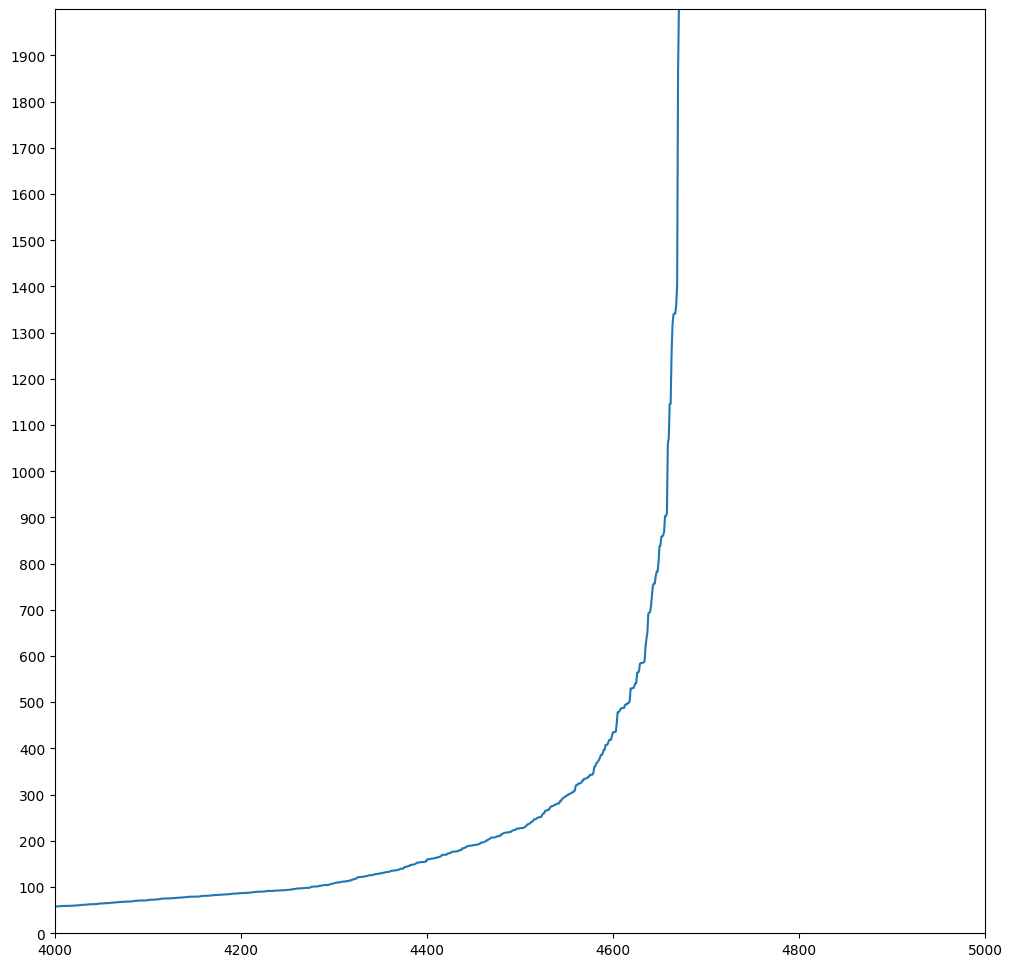

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(distances)
plt.xlim([4000,5000])
plt.ylim([100,2000])
plt.yticks(np.arange(0,2000,100))
plt.ticklabel_format(useOffset=False,style='plain')

In [ ]:
dbscan = DBSCAN(eps = 500, min_samples = 4).fit(input) # fitting the model
customer_quantity_price_dbscan = customer_quantity_price[:]
customer_quantity_price_dbscan['DBSCAN'] = dbscan.labels_

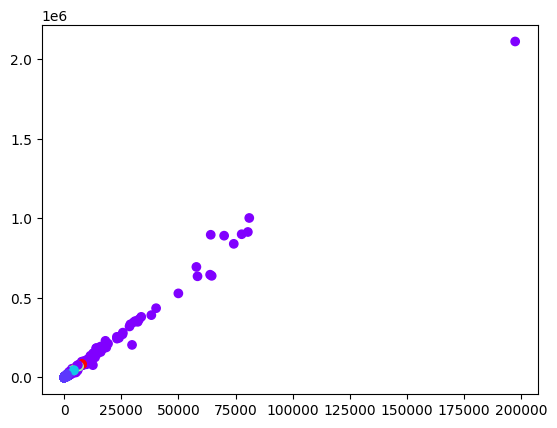

In [ ]:
plt.scatter(customer_quantity_price_dbscan['TotalQuantity'],customer_quantity_price_dbscan['TotalMoney'],c=customer_quantity_price_dbscan['DBSCAN'],cmap='rainbow')

## Sau khi bỏ outlier(Chưa hoàn thành)

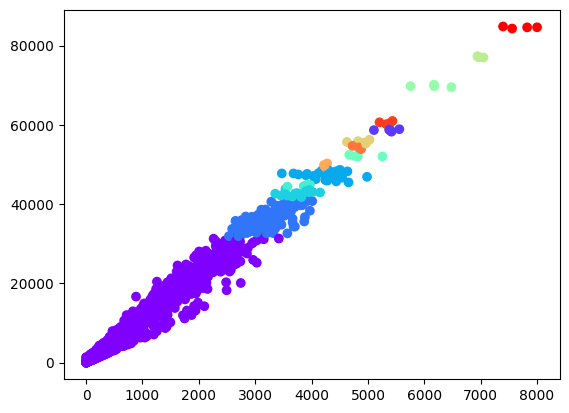

In [ ]:
input = customer_quantity_price_dbscan[:]
input = input.loc[input['DBSCAN']!= -1]
plt.scatter(input['TotalQuantity'],input['TotalMoney'],c=input['DBSCAN'],cmap='rainbow')

In [ ]:
customer_quantity_price_outlier_dbscan = customer_quantity_price_dbscan.loc[customer_quantity_price_dbscan['DBSCAN']==-1]
customer_quantity_price_outlier_dbscan = customer_quantity_price_outlier_dbscan.drop(customer_quantity_price_outlier_dbscan.columns[3],axis=1)
customer_quantity_price_outlier_dbscan.to_csv("./data/customer_quantity_price_outlier_dbscan.csv",index=False)

## Nhận xét và so sánh 2 thuật toán:

In [ ]:
print("Outlier tìm được theo DBSCAN: ",customer_quantity_price_outlier_dbscan.shape[0])
print("Outlier tìm được theo phương pháp số học: ",customer_quantity_price_outlier_statistic.shape[0])

Outlier tìm được theo DBSCAN:  137
Outlier tìm được theo phương pháp số học:  409


## Loại bỏ outlier

In [ ]:
customer_quantity_price_without_outlier = customer_quantity_price[~customer_quantity_price.isin(customer_quantity_price_outlier_statistic)]
customer_quantity_price_without_outlier.dropna(inplace=True)

<Axes: xlabel='TotalQuantity'>

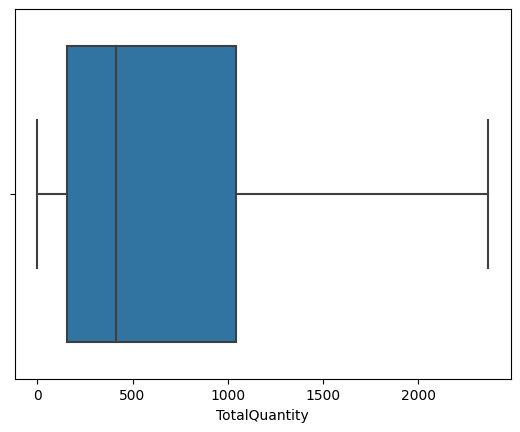

In [ ]:
sb.boxplot(x='TotalQuantity',data=customer_quantity_price,showfliers = False)

##

# Tìm outlier transaction theo TotalMoney và Quantity

# Vẽ biểu đồ

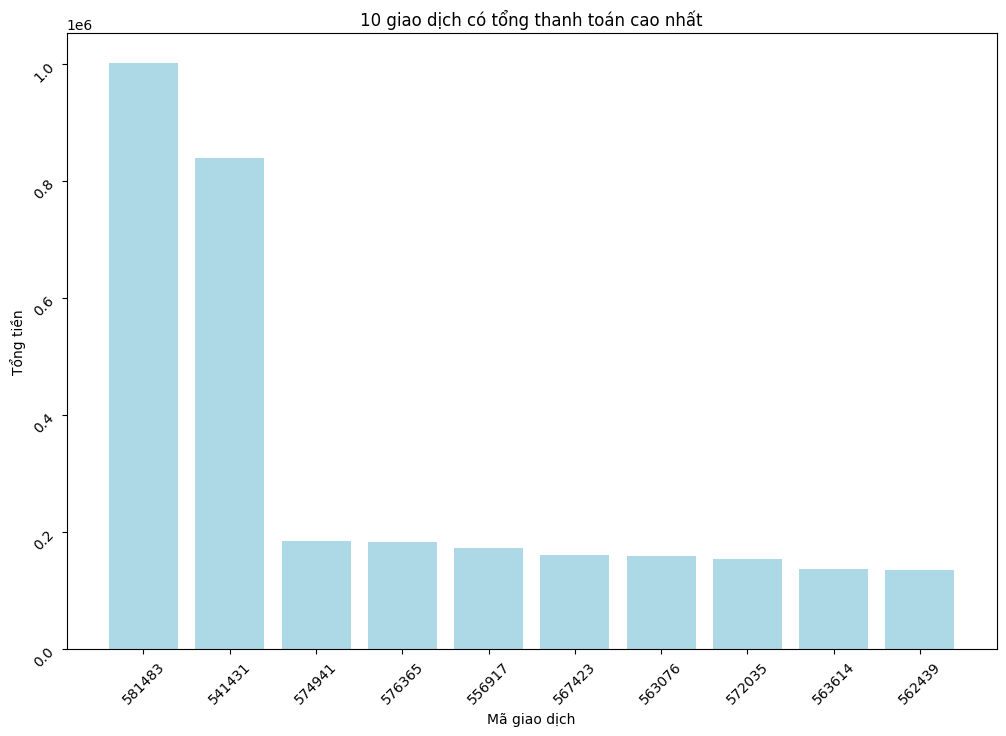

In [ ]:
# Variable to Store Data
listTransaction = data['TransactionNo'].unique()
listTotalMoney = []

# Loop for Store Data
for i in listTransaction:
    totalMoney = data['TotalMoney'].loc[data['TransactionNo'] == i].sum()
    listTotalMoney.append(totalMoney)

# Dictionary for DataFrame
dictTransaction = {
    'TransactionNo' : listTransaction,
    'TotalMoney' : listTotalMoney
}

# Adjust DataFrame
dfTransaction = pd.DataFrame(dictTransaction)
dfTransaction = dfTransaction.sort_values('TotalMoney',ascending=False).head(10)
dfTransaction = dfTransaction.reset_index(drop=True)

# dfTransaction.to_csv('dfTransaction.csv')
# dfTransaction = pd.read_csv("dfTransaction.csv")

# Create Figure
plt.figure(figsize = (12,8))
plt.bar(data = dfTransaction, x = 'TransactionNo',height = 'TotalMoney', color = 'lightblue')
plt.title('10 giao dịch có tổng thanh toán cao nhất')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.xlabel('Mã giao dịch')
plt.ylabel('Tổng tiền')
plt.show()

#### 10 sản phẩm có doanh thu cao nhất

In [ ]:
# Variable to Store Data
listProduct = data['ProductNo'].unique()
listTotalMoney = []

# Loop for Store Data
for i in listProduct:
    totalMoney = data['TotalMoney'].loc[data['ProductNo'] == i].sum()
    listTotalMoney.append(totalMoney)

# Dictionary for DataFrame
dictProduct = {
    'ProductNo' : listProduct,
    'TotalMoney' : listTotalMoney
}

# Adjust DataFrame
dfProduct = pd.DataFrame(dictProduct)
dfProduct = dfProduct.sort_values('TotalMoney',ascending=False).head(10)
dfProduct = dfProduct.reset_index(drop=True)

# Create Figure
plt.figure(figsize = (12,8))
plt.bar(data = dfProduct, x = 'ProductNo',height = 'TotalMoney', color = 'lightblue')
plt.title('10 sản phẩm có doanh thu cao nhất')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.xlabel('Mã sản phẩm')
plt.ylabel('Tổng tiền')
plt.show()

# Show Product Number, Product Name and Total Money
listProductName = []
for i in dfProduct['ProductNo']:
    a = data['ProductName'].loc[data['ProductNo'] == i].unique()[0]
    listProductName.append(a) 
dfProduct['ProductName'] = listProductName
print(dfProduct)

#### Giá của 10 sản phẩm có doanh thu cao nhất

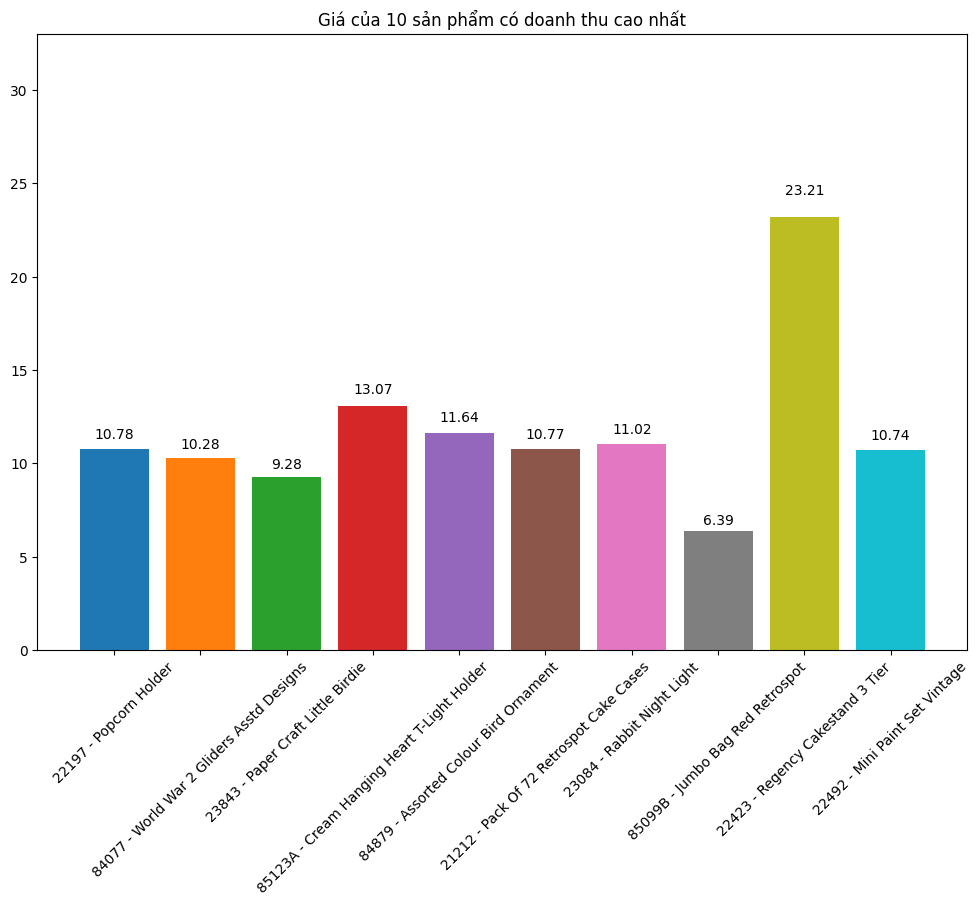

In [ ]:
plt.figure(figsize=(12,8))

listProductNo = dfProduct['ProductNo'].unique().copy()
listProductName = dfProduct['ProductName'].unique().copy()

for i in range(len(listProductNo)):
    pricePiece = round(data['Price'].loc[data['ProductNo']==listProductNo[i]].mean(),2)
    labelx = listProductNo[i]+' - '+listProductName[i]
    plt.text(labelx,pricePiece*1.05,pricePiece,ha='center')
    plt.bar(x = labelx, height = pricePiece)

plt.ylim(0,33)
plt.title('Giá của 10 sản phẩm có doanh thu cao nhất')
plt.xticks(rotation = 45)
plt.show()

#### Tổng số lượng bán ra của 10 sản phẩm có doanh thu cao nhất

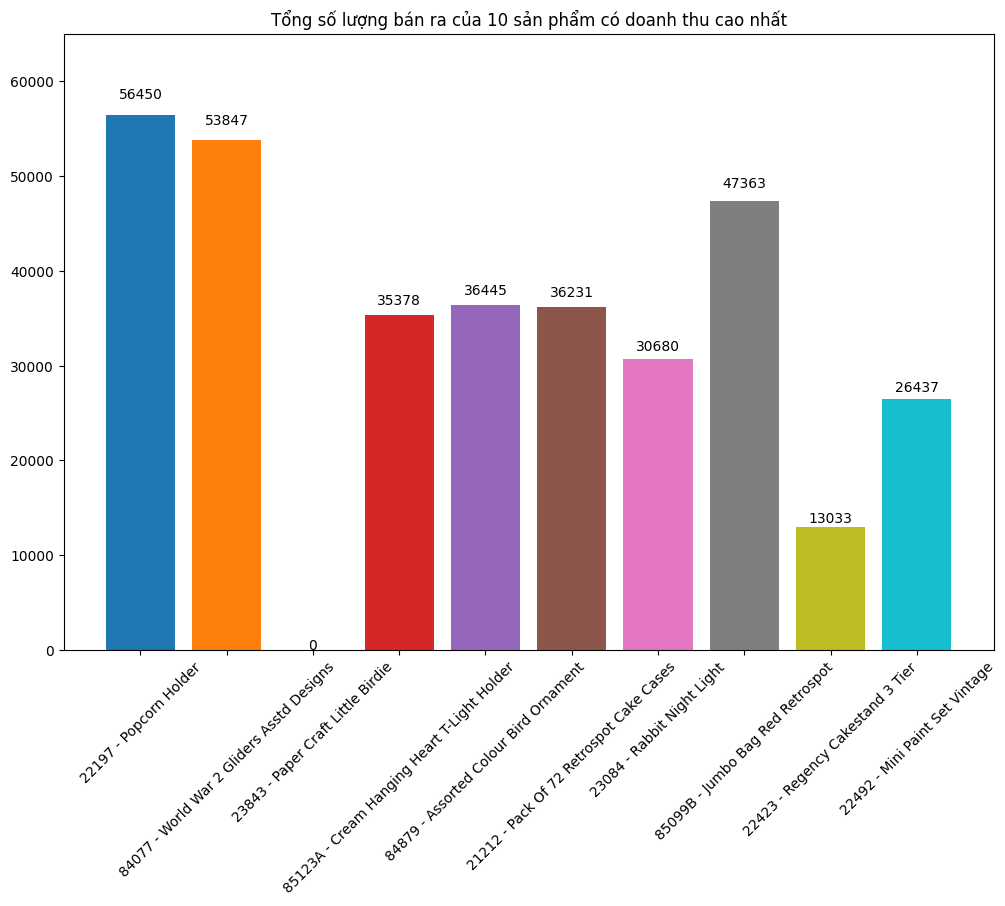

In [ ]:
plt.figure(figsize=(12,8))

listProductNo = dfProduct['ProductNo'].unique().copy()
listProductName = dfProduct['ProductName'].unique().copy()

for i in range(len(listProductNo)):
    totalQuantity = round(data['Quantity'].loc[data['ProductNo']==listProductNo[i]].sum(),2)
    labelx = listProductNo[i]+' - '+listProductName[i]
    plt.text(labelx,totalQuantity*1.03,totalQuantity,ha='center')
    plt.bar(x = labelx, height = totalQuantity)

plt.ylim(0,65000)
plt.title('Tổng số lượng bán ra của 10 sản phẩm có doanh thu cao nhất')
plt.xticks(rotation = 45)
plt.show()

#### 10 quốc gia có doanh số mua hàng cao nhất

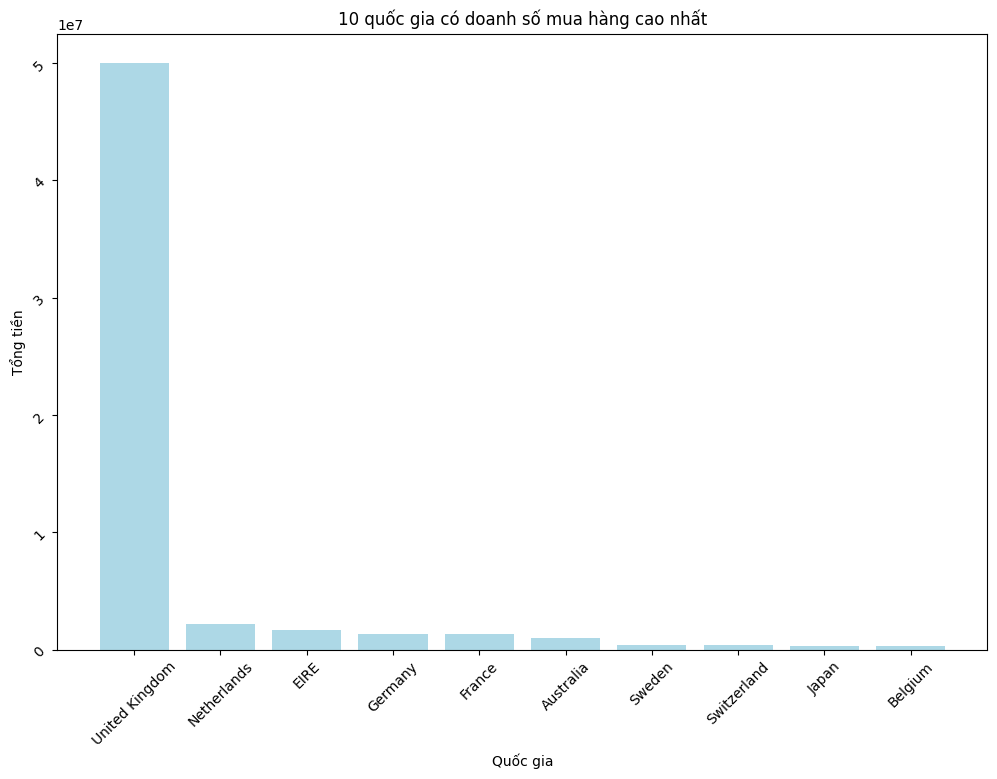

      CountryName   TotalMoney
0  United Kingdom  49994030.17
1     Netherlands   2147811.39
2            EIRE   1660645.07
3         Germany   1350265.40
4          France   1316880.98
5       Australia    988756.35
6          Sweden    396042.61
7     Switzerland    358423.61
8           Japan    283293.47
9         Belgium    271346.98


In [ ]:
# Variable to Store
listCountry = data['Country'].unique()
listTotalMoney = []

# Loop to Store Data
for i in listCountry:
    totalMoney = round(data['TotalMoney'].loc[data['Country'] == i].sum(),2)
    listTotalMoney.append(totalMoney)

# Dictionary for Dataframe
dictCountry = {
    'CountryName' : listCountry,
    'TotalMoney' : listTotalMoney
}

# Adjust Data Frame
dfCountry = pd.DataFrame(dictCountry)
dfCountry = dfCountry.sort_values('TotalMoney',ascending = False).head(10)
dfCountry = dfCountry.reset_index(drop = True)

# Create Figure
plt.figure(figsize = (12,8))
plt.bar(data = dfCountry, x = 'CountryName',height = 'TotalMoney', color = 'lightblue')
plt.title('10 quốc gia có doanh số mua hàng cao nhất')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.xlabel('Quốc gia')
plt.ylabel('Tổng tiền')
plt.show()

# Show dfCountry
print(dfCountry)

In [ ]:
dfCountry.to_csv("./data/dfCountry.csv")

#### Tổng doanh thu của từng tháng trong năm 2019

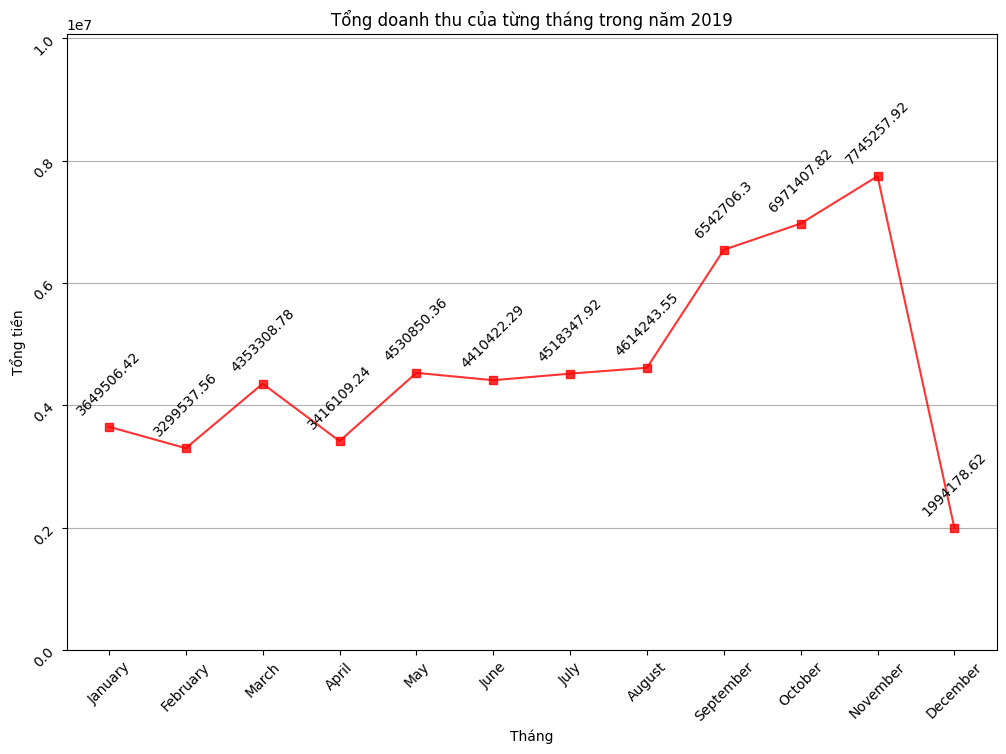

In [ ]:
# Variable to Store
listMonth = []
listTotalMoney = []
for i in data['Month'].unique():
    monthName = dt.datetime.strptime(str(i), "%m")
    monthName = monthName.strftime("%B")
    listMonth.append(monthName)
for i in data['Month'].unique():
    totalMoney = round(data['TotalMoney'].loc[(data['Month']==i)&(data['Year']==2019)].sum(),2)
    listTotalMoney.append(totalMoney)
    
# Dictionary for DataFrame
dictMonth = {
    'MonthName' : listMonth,
    'TotalMoney' : listTotalMoney
}

# Adjust Data Frame
dfMonth = pd.DataFrame(dictMonth)
dfMonth = dfMonth.iloc[::-1]


# Create Figure
plt.figure(figsize = (12,8))
plt.plot(dfMonth['MonthName'], dfMonth['TotalMoney'], color = 'Red', marker = 's',alpha = 0.8)
plt.title('Tổng doanh thu của từng tháng trong năm 2019')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.xlabel('Tháng')
plt.ylabel('Tổng tiền')
for i in dfMonth['MonthName']: 
    text = str(dfMonth['TotalMoney'].loc[dfMonth['MonthName'] == i].values[0])
    y = dfMonth['TotalMoney'].loc[dfMonth['MonthName'] == i]+(dfMonth['TotalMoney'].min()*0.1)
    plt.text(i,y,text, ha = 'center', rotation = 45) 
plt.ylim(0,dfMonth['TotalMoney'].max()*1.3)
plt.grid(axis = 'y')
plt.show()

In [ ]:
dfMonth.to_csv("./data/dfMonth.csv")

In [ ]:
def searchTotalMoney(country,month):
    return round(data['TotalMoney'].loc[(data['Country'] == country)&(data['Month'] == month)].sum(),2)

def searchHighestTotalMoneyCountry(month):
    listMoney = []
    maxCountry = 'none'
    for i in listCountry:
        total = searchTotalMoney(i,month)
        listMoney.append(total)
        maxMoney = max(listMoney) 
        if total >= maxMoney:
            maxCountry = i 
    return([maxMoney,maxCountry])

listTotalMoney = []
listHighCountry = []

for i in data['Month'].unique():
    templist = searchHighestTotalMoneyCountry(i)
    listTotalMoney.append(templist[0])
    listHighCountry.append(templist[1])

dictHighCountMonth = {
    'Month' : listMonth,
    'Country Name' : listHighCountry,
    'Total Money' : listTotalMoney
}             

dfCountMonth = pd.DataFrame(dictHighCountMonth)
dfCountMonth = dfCountMonth.iloc[::-1]
dfCountMonth = dfCountMonth.reset_index(drop = True)
dfCountMonth

,Month,Country Name,Total Money
0,January,United Kingdom,2766521.62
1,February,United Kingdom,2704022.15
2,March,United Kingdom,3537492.90
3,April,United Kingdom,3053768.60
4,May,United Kingdom,3689507.59
5,June,United Kingdom,3500065.77
6,July,United Kingdom,3765557.98
7,August,United Kingdom,3667938.41
8,September,United Kingdom,5480320.68
9,October,United Kingdom,5632406.43


In [ ]:
dfCountMonth.to_csv("./data/dfCountMonth.csv")

#### Tổng số tiền mỗi tháng bán được từ 10 quốc gia có tổng doanh số bán cao nhất trong năm 2019

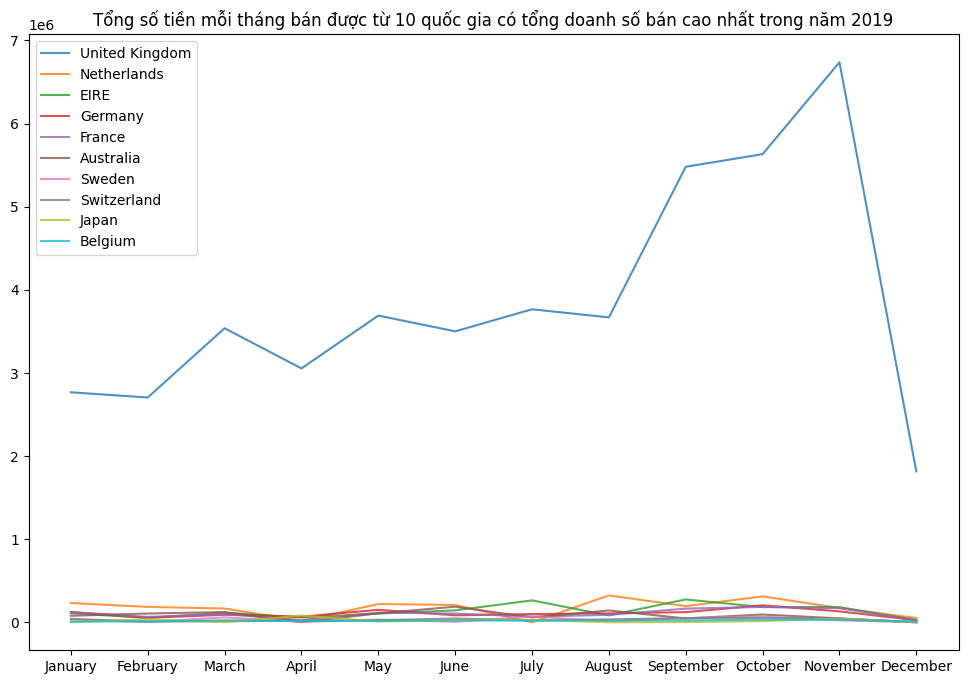

In [ ]:
plt.figure(figsize = (12,8))
topTenCountry = dfCountry['CountryName'].unique().copy()
listMonthTopTen = listMonth.reverse()
listMonthTopTen = listMonth 

for i in topTenCountry:
    totalMoneyCountry = []
    for j in data['Month'].unique():
        moenyCountry = round(data['TotalMoney'].loc[(data['Country']==i)&((data['Month']==j)&(data['Year']==2019))].sum(),2)
        totalMoneyCountry.append(moenyCountry)
    totalMoneyCountry.reverse()
    plt.plot(listMonthTopTen, totalMoneyCountry,alpha = 0.8) 

plt.title('Tổng số tiền mỗi tháng bán được từ 10 quốc gia có tổng doanh số bán cao nhất trong năm 2019')
plt.legend(topTenCountry)
plt.show()

#### Tổng tiền mỗi tháng bán được từ 10 sản phẩm hàng đầu có doanh thu cao nhất trong năm 2019

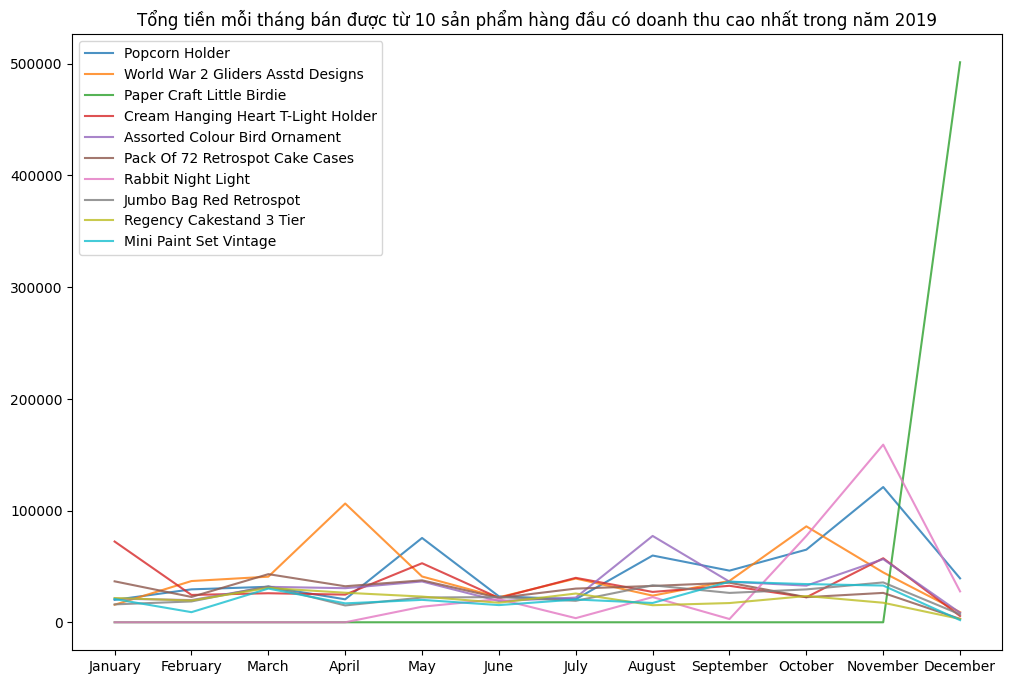

In [ ]:
plt.figure(figsize = (12,8))
listProductNo = dfProduct['ProductNo'].unique().copy()  
listProductName = dfProduct['ProductName'].unique().copy()

for i in listProductNo:
    totalMoneyCountry = []
    for j in data['Month'].unique():
        moenyCountry = round(data['TotalMoney'].loc[(data['ProductNo']==i)&((data['Month']==j)&(data['Year']==2019))].sum(),2)
        totalMoneyCountry.append(moenyCountry)
    totalMoneyCountry.reverse()
    plt.plot(listMonthTopTen, totalMoneyCountry,alpha = 0.8) 

plt.title('Tổng tiền mỗi tháng bán được từ 10 sản phẩm hàng đầu có doanh thu cao nhất trong năm 2019')
plt.legend(listProductName)
plt.show()

#### Tổng số lượng mỗi tháng bán được từ 10 sản phẩm có doanh thu cao nhất trong năm 2019

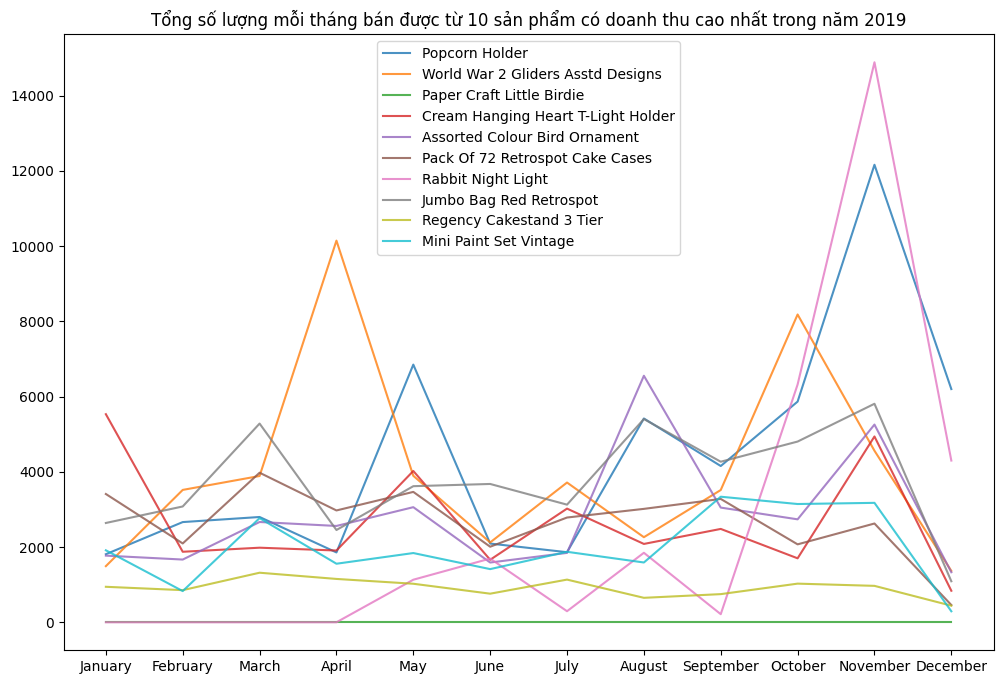

In [ ]:
plt.figure(figsize = (12,8))
listProductNo = dfProduct['ProductNo'].unique().copy()  
listProductName = dfProduct['ProductName'].unique().copy()

for i in listProductNo:
    totalMoneyCountry = []
    for j in data['Month'].unique():
        moenyCountry = round(data['Quantity'].loc[(data['ProductNo']==i)&((data['Month']==j)&(data['Year']==2019))].sum(),2)
        totalMoneyCountry.append(moenyCountry)
    totalMoneyCountry.reverse()
    plt.plot(listMonthTopTen, totalMoneyCountry,alpha = 0.8) 

plt.title('Tổng số lượng mỗi tháng bán được từ 10 sản phẩm có doanh thu cao nhất trong năm 2019')
plt.legend(listProductName)
plt.show()

# Trả lời những câu hỏi đặt ra:
#### Xu hướng bán hàng thay đổi qua từng tháng như thế nào?
Dựa vào biểu đồ **'Tổng doanh thu từng tháng trong năm 2019'**, doanh số của doanh nghiệp này tăng tương đối hàng tháng kể từ tháng 1, nhưng vào tháng 12 năm 2019, doanh số giảm đáng kể. Có thể giải thích sự giảm này dựa vào biểu đồ **'Tổng số tiền mỗi tháng bán được từ 10 quốc gia có tổng doanh số bán cao nhất trong năm 2019'**, có thể thấy doanh số bán đến Anh vào tháng 12 năm 2019 không tốt như các tháng trước.

#### Những sản phẩm được mua thường xuyên nhất là gì?
Dựa vào biểu đồ **'Tổng số lượng bán ra của 10 sản phẩm có doanh số cao nhất'**, các sản phẩm được mua nhiều nhất và mang lại lợi nhuận cao là *Popcorn Holder, World War 2 Gliders Asstd Designs, Paper Craft Little Birdie, Cream Hanging Heart T-Light Holder, Assorted Colour Bird Ornament, Pack Of 72 Retrospot Cake Cases, Rabbit Night Light, Jumbo Bag Red Retrospot, Regency Cakestand 3 Tier và Mini Paint Set Vintage*. Tuy nhiên, cũng từ biểu đồ này, ta có thể thấy một trong số các sản phẩm có số lượng 0 nhưng vẫn được bao gồm trong biểu đồ **'10 sản phẩm có doanh số cao nhất'**, điều đó có nghĩa là sản phẩm này gây thiệt hại về lợi nhuận nhưng vẫn có nhiều giao dịch mua sản phẩm này.

#### Mỗi giao dịch khách hàng thường mua bao nhiêu sản phẩm?
Dựa vào biểu đồ **'10 giao dịch có tổng thanh toán cao nhất'**, khách hàng dường như mua số lượng sản phẩm khác nhau dựa trên nhu cầu của họ, nhưng ở đây chúng ta có thể thấy sự khác biệt có thể rất đáng kể.

#### Đâu là phân khúc khách hàng có lợi nhuận cao nhất?
Nhóm khách hàng mang lại lợi nhuận cao nhất là nhóm khách hàng mua sản phẩm được bao gồm trong biểu đồ **'Giá của 10 sản phẩm có doanh thu cao nhất'**, biểu đồ **'Tổng số lượng bán ra của 10 sản phẩm có doanh số nhất'** và biểu đồ **'10 sản phẩm có doanh thu cao nhất'**, cùng với nhóm khách hàng đến từ quốc gia được bao gồm trong biểu đồ **'10 quốc gia có doanh số bán cao nhất'**.

#### Dựa trên những câu hỏi trên, có thể đề xuất chiến lược nào cho doanh nghiệp để thu được nhiều lợi nhuận hơn?
Dựa trên những phát hiện, có một số chiến lược để doanh nghiệp đạt được lợi nhuận cao hơn.

Thứ nhất, dựa trên biểu đồ **'Tổng số lượng bán ra của 10 sản phẩm có doanh số nhất'**, có một sản phẩm không mang lại doanh thu nhưng vẫn được bao gồm trong biểu đồ **'10 sản phẩm có doanh số bán cao nhất'**, nên sản phẩm này cần cải thiện chất lượng để mang lại lợi nhuận cao hơn. 

Thứ hai, tăng doanh số bán hàng, cũng như là cải thiện chất lượng cho các sản phẩm được bao gồm trong biểu đồ **'10 sản phẩm có doanh số bán cao nhất'** bằng các phương pháp tiếp thị đa dạng để thu hút người mua.

Thứ ba, tăng doanh số bán hàng tại các quốc gia được bao gồm trong biểu đồ **'10 quốc gia có doanh số bán cao nhất'** bằng các phương pháp tiếp thị đa dạng, quảng cáo các sản phẩm tại các quốc gia không được bao gồm để thu hút và tăng sự quan tâm của người mua từ những quốc gia này.. 

# Tìm các outlier khách hàng mua hàng số lượng nhiều

# Thuật toán Gom cụm

Text(0, 0.5, 'WCSS')

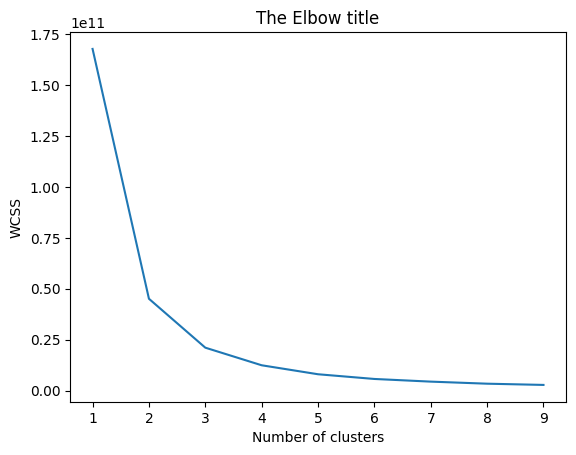

In [ ]:
wcss=[] #is the sum of the squared distance between each point and the centroid in a cluster.
for i in range (1,10):
    kmeans = KMeans(i)
    kmeans.fit(customer_quantity_price_without_outlier.iloc[:,1:3])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
kmeans = KMeans(3)
kmeans.fit(customer_quantity_price_without_outlier.iloc[:,1:3])#Lấy 2 cột totalquantity và total price làm input
identified_clusters = kmeans.fit_predict(customer_quantity_price_without_outlier.iloc[:,1:3])
customer_quantity_price_without_outlier['Clusters'] = identified_clusters
customer_quantity_price_without_outlier.head()

,CustomerNo,TotalQuantity,TotalPrice,Clusters
0,17490.0,1134.0,13538.07,1
3,13426.0,2245.0,25893.59,2
5,14441.0,446.0,6326.48,1
8,17001.0,2164.0,21680.74,2
9,15694.0,1680.0,21902.34,2


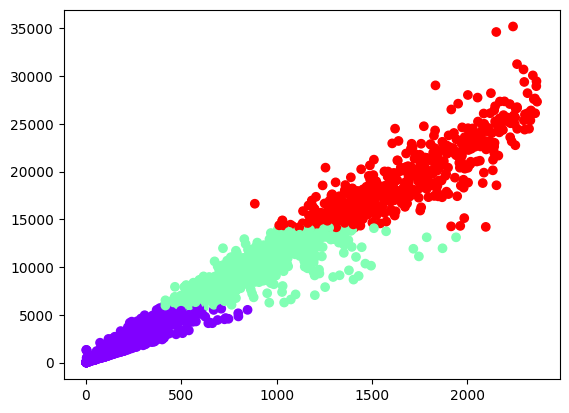

In [ ]:
#Cần thêm xlab và ylab
plt.scatter(customer_quantity_price_without_outlier['TotalQuantity'],customer_quantity_price_without_outlier['TotalMoney'],c=customer_quantity_price_without_outlier['Clusters'],cmap='rainbow')

# Thuật toán FP-Growth

In [ ]:
if not exists("./transactionEncoder.csv"):
    transactionFreq = []
    for i in data['TransactionNo'].unique():#Với mỗi transactionNo
        transactionFreqRow = []
        quantity = data[data['TransactionNo'] == i]['Quantity'].to_list()
        productNo = data[data['TransactionNo'] == i]['ProductNo'].to_list()
        for j in range(len(productNo)): # Với mỗi productNo
            transactionFreqRow.extend(repeat(productNo[j],quantity[j]))
        transactionFreq.append(transactionFreqRow)
    transactionEncoder = TransactionEncoder()
    transactionEncoder_array = transactionEncoder.fit(transactionFreq).transform(transactionFreq)
    transactionEncoder_df = pd.DataFrame(transactionEncoder_array,columns=transactionEncoder.columns_)
    transactionEncoder_df.to_csv("./data/transactionEncoder.csv", sep=',', encoding='utf-8')
else: transactionEncoder_df = pd.read_csv("./transactionEncoder.csv");


In [ ]:
transactionEncoder_df.drop(transactionEncoder_df.iloc[:,0:1],inplace=True, axis=1)

In [ ]:
frequentItemset = fpgrowth(transactionEncoder_df,min_support=0.01, use_colnames=True)
frequentItemset

,support,itemsets
0,0.040314,(22138)
1,0.032718,(23300)
2,0.017049,(22371)
3,0.012819,(22721)
4,0.012733,(22723)
...,...,...
1346,0.012172,"(20711, 22386)"
1347,0.010186,"(21931, 20711, 85099B)"
1348,0.010057,"(20711, 22386, 85099B)"
1349,0.012129,"(22579, 22578)"


In [ ]:
frequentItemset.to_csv("./data/apriori.csv", sep=',', encoding='utf-8')